# 3 Pre-processing and Training

This notebook will focus on creating more new featurse, such as lagged features and prepare the data for modelling. we will encode categorical variables, apply standard scaling to the features. Finally we will split the data into training and test datasets and create a basic modeling that will be used as a bench mark.

## 3.1 Contents
 * 3  [Pre-processing and training](#3-Pre-processing-and-Training)  
 * 3.1  [Contents](#3.1-Contents)  
 * 3.2  [Import libraries](#3.2-Import-libraries)  
 * 3.3  [Load the merged dataset](#3.3-Load-the-merged-dataset)  
 * 3.4  [Feature engineering](#3.4-Feature-engineering)
    * 3.4.1 [Lagged features](#3.4.1-Lagged-features)
    * 3.4.2 [Rolled features](#3.4.2-Rolled-features)
 * 3.5  [Split the data into training and test data](#3.5-Split-the-data-into-training-and-test-data)
    * 3.5.1 [Encode, scale  and split into X and y](#3.5.1-Encode,-scale-and-split-into-X-and-y)
 * 3.6 [Error metrics](#3.6-Error-metrics)
 * 3.7 [Base line model](#3.7-Base-line-model)
 * 3.8 [Linear regression models](#3.8-Linear-regression-models)
    * 3.8.1 [Simple linear regression](#3.8.1-Simple-linear-regression)
    * 3.8.2 [Elastic net regression](#3.8.2-Elastic-net-regression)
 * 3.9 [Random forest](#3.9-Random-forest)
 * 3.10 [Comparison of model performace](#3.10-Comparison-of-model-performace)
 * 3.11 [Saving models](#3.11-Saving-models)
 * 3.12 [Summary](#3.12-Summary)


## 3.2 Import libraries

In [691]:
1# Import relevant libraries

import os, types
import io, requests

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import datetime as dt
import pickle

# sklearn functions
from sklearn import __version__ as sklearn_version
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator, RegressorMixin

# error metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy.stats import norm

from library.sb_utils import save_file

In [521]:
plt.style.use('fivethirtyeight')
# print(plt.style.available)

## 3.3 Load the merged dataset

In [2]:
# Reading back the saved file to check it was written as intended
merged_dict = np.load('./modified_data/trim_weather_dict.npy',allow_pickle='TRUE').item()

In [194]:
# merged_dict['Coast'].head

In [4]:
merged_dict['Coast'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 109249 entries, 2009-01-01 00:00:00 to 2021-06-19 00:00:00
Freq: H
Data columns (total 29 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   tempC            109249 non-null  float64       
 1   windspeedKmph    109249 non-null  float64       
 2   winddirDegree    109249 non-null  float64       
 3   precipMM         109249 non-null  float64       
 4   humidity         109249 non-null  float64       
 5   visibility       109249 non-null  float64       
 6   pressure         109249 non-null  float64       
 7   cloudcover       109249 non-null  float64       
 8   HeatIndexC       109249 non-null  float64       
 9   DewPointC        109249 non-null  float64       
 10  WindChillC       109249 non-null  float64       
 11  WindGustKmph     109249 non-null  float64       
 12  FeelsLikeC       109249 non-null  float64       
 13  uvIndex          109249 non-null

## 3.4 Feature engineering

In the first notebook, we created some features such as year, month, day, hour, weekday based on the datetime information. In addition we created features to indicate whethera given day is holiday or it is workingday. In second notebook, we added a feature called apparent temperature which combined the effect of temperature, windspeed and humudity.

In this section we will be adding more features. We will create lagged features on the Load and apparent temperature columns:
    - lagged features -- shift the corresponding value (load or apparent temperature) by a value. the values could be an hour, a week, a month or a year. 
    - Rolled features -- creating new features such as mean, median, standard deviation, minimum and maximum values over a 24 hr period and keep repeating this by shifting the window a hour at a time.
<p>&nbsp;</p>


### 3.4.1 Lagged features

In [5]:
# function to create laged features

def LaggedFeatures(data,feature,laglist, dropna=True):
    
    """ This function creates lagged feature by shifting the values of a given 
    column by the specified amount.
    
    data : is the input data in a dictionary format
    feature :  contains the name of the column to lag or shift
    laglist : contains the lag amount to shift the feature column by
    dropna : if true will drop the NaN created after shifting
    
    """    
    if type(data) is dict:
        new_dict = {}
    
        for key, values in data.items():
            df = data[key].copy()

            for j in range(len(feature)):
                for i in laglist:
                    df['%s_lag%d'%(feature[j],i)] = df[feature[j]].shift(i)
            if dropna:
                df = df.dropna()
            else:
                df = df
            new_dict[key] = df
        return new_dict
    else:
        print('input data should be a dictionary')
        return None


### 3.4.2 Rolled features

In [6]:
# Create rolling values
# we will create rolling mean, median, standard_deviation, min, and max for a period of 24hrs

def RollingFeatures(data, feature):
    
    """ A function to create rolled (moving) functions on a given column.
    the function will created the rolled mean,median, standar deviation,
    minumum and maximum value using a window of 24 hrs. It then shifts by 1hr
    and repeats the process until the end of the data is reached. The function
    will drop NaN by default.
    
    data : is the input data in a dictionary format
    feature :  contains the name of the column to create the roll
    """
    
    
    if type(data) is dict:
        new_dict = {}
    
        for key, values in data.items():
        
            df = data[key].copy()
            df['roll_mean'] = df[feature].rolling(24).mean().shift(1)
            df['roll_median'] = df[feature].rolling(24).median().shift(1)
            df['roll_std'] = df[feature].rolling(24).std().shift(1)
            df['roll_min'] = df[feature].rolling(24).min().shift(1)
            df['roll_max'] = df[feature].rolling(24).max().shift(1)
            df=df.loc[:,~df.columns.duplicated()]
            df = df.dropna()
            data[key] = df
        return data
    else:
        print('input data should be a dictionary')
        return None

In [9]:
# Specify the lag values and features
# Call the functions LaggedFeatures and RollingFeatures

lag_list = [1,2,3,4,5,6,12,24,48,120,144,168,192,336,360,504,672,768,8064,8760]
feature = ['load','appr_temp']

lagged_dict = LaggedFeatures(merged_dict,feature,lag_list,dropna=False)
lagged_dict = RollingFeatures(lagged_dict, ['load'] )

In [13]:
lagged_dict['Coast'].head()

,tempC,windspeedKmph,winddirDegree,precipMM,humidity,visibility,pressure,cloudcover,HeatIndexC,DewPointC,...,appr_temp_lag504,appr_temp_lag672,appr_temp_lag768,appr_temp_lag8064,appr_temp_lag8760,roll_mean,roll_median,roll_std,roll_min,roll_max
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-01 00:00:00,8.0,14.0,335.0,0.00,90.0,10.0,1026.0,70.0,8.0,7.0,...,1.855022,1.221840,21.756105,1.802891,6.385142,8689.593481,8983.254286,693.692186,7466.132671,9684.165433
2010-01-01 01:00:00,7.0,19.5,336.5,0.05,88.5,10.0,1027.5,76.0,7.0,5.5,...,1.640410,0.720318,15.895605,0.989257,5.422290,8673.585860,8983.254286,707.006814,7466.132671,9684.165433
2010-01-01 02:00:00,7.0,19.5,336.5,0.05,88.5,10.0,1027.5,76.0,7.0,5.5,...,1.640410,0.720318,15.895605,0.989257,5.422290,8671.454090,8983.254286,709.743461,7466.132671,9684.165433
2010-01-01 03:00:00,6.0,25.0,338.0,0.10,87.0,10.0,1029.0,82.0,6.0,4.0,...,1.425798,0.218796,10.035106,0.175623,4.459439,8679.994104,8983.254286,696.135884,7466.132671,9684.165433
2010-01-01 04:00:00,5.5,15.5,172.5,0.15,86.5,9.5,1029.0,51.5,5.5,3.5,...,1.880856,-0.276466,9.295545,0.124410,4.777614,8687.679231,8983.254286,683.047648,7503.767527,9684.165433


In [294]:
# lagged_dict['Coast'].info()

## 3.5 Split the data into training and test data

We need to be careful when splitting the data into training and test for a time series data. Since we use historic data to predict the fiture, we need to avoid using feature data into our training data and viceversa. This means we can not split the data randomly. we have to select a time where, any time before it will be our training dataset and anything after it will be our test dataset.

We have 12 years worth of data and we will isolate a year (1 year = 8760 hours) data a test dataset,(keep in mind the year 2021 is not over, so the test set will start half way from 2020 to the current time) and keep the remaining ~11 years for training. 
<p>&nbsp;</p>

In [184]:
# create dictionaries for training and testing datasets
# we will use 8760 + 1 to make sure the separation happens at the end of 1 day
split_index = 8761
lagged_train_dict = {}
lagged_test_dict = {}
for key, values in lagged_dict.items():
    lagged_train_dict[key] = lagged_dict[key].iloc[:-split_index, :]
    lagged_test_dict[key] = lagged_dict[key].iloc[-split_index:, :]

<p>&nbsp;</p>
To check the splitting process is done correctly, we print the end of our training data and the beginning of the test data. we see that there is no overlap and no gap, the test data starts right where our training data stops

In [430]:
# use the coast region as an example
lagged_train_dict['Coast'].tail()

,tempC,windspeedKmph,winddirDegree,precipMM,humidity,visibility,pressure,cloudcover,HeatIndexC,DewPointC,WindChillC,WindGustKmph,FeelsLikeC,uvIndex,appr_temp,region,winddir16Point,weatherCategory,load,dates,hour,day,month,year,weekday,holiday,working_day,covid_confirmed,covid_deaths,load_lag1,load_lag2,load_lag3,load_lag4,load_lag5,load_lag6,load_lag12,load_lag24,load_lag48,load_lag120,load_lag144,load_lag168,load_lag192,load_lag336,load_lag360,load_lag504,load_lag672,load_lag768,load_lag8064,load_lag8760,appr_temp_lag1,appr_temp_lag2,appr_temp_lag3,appr_temp_lag4,appr_temp_lag5,appr_temp_lag6,appr_temp_lag12,appr_temp_lag24,appr_temp_lag48,appr_temp_lag120,appr_temp_lag144,appr_temp_lag168,appr_temp_lag192,appr_temp_lag336,appr_temp_lag360,appr_temp_lag504,appr_temp_lag672,appr_temp_lag768,appr_temp_lag8064,appr_temp_lag8760,roll_mean,roll_median,roll_std,roll_min,roll_max
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-06-18 19:00:00,29.5,17.0,167.0,0.0,50.5,10.0,1014.0,11.5,31.5,18.5,29.5,21.0,31.5,1.0,29.000041,Coast,SSE,cloudy,17815.793126,2020-06-18,19.0,18.0,6.0,2020.0,Thursday,0.0,1.0,18552.0,475.0,18488.657441,18820.872155,18792.410708,18556.811643,18037.887111,17239.587005,11600.525754,18111.945370,18129.685008,16746.980925,17050.384350,17252.421032,17192.778634,17253.475534,14683.955800,14562.831834,16046.184753,14289.389094,18826.277984,19077.034940,30.148444,31.146691,31.146691,32.144937,32.092012,32.092012,28.575176,30.549412,30.893480,28.424898,31.106676,28.325483,29.165462,31.930419,30.558998,30.801465,30.465177,24.058464,31.934493,31.780152,14937.708409,15048.484382,2824.080573,11085.059486,18820.872155
2020-06-18 20:00:00,29.5,17.0,167.0,0.0,50.5,10.0,1014.0,11.5,31.5,18.5,29.5,21.0,31.5,1.0,29.000041,Coast,SSE,cloudy,16898.329761,2020-06-18,20.0,18.0,6.0,2020.0,Thursday,0.0,1.0,18552.0,475.0,17815.793126,18488.657441,18820.872155,18792.410708,18556.811643,18037.887111,12133.486079,17234.679776,17269.263083,16011.828481,16263.397243,16434.543869,16348.162692,16406.647320,14448.854583,13920.584354,15382.857164,13671.166705,18189.422864,18309.911489,29.000041,30.148444,31.146691,31.146691,32.144937,32.092012,28.575176,30.549412,30.893480,28.424898,31.106676,28.325483,29.165462,31.930419,30.558998,30.801465,30.465177,24.058464,31.934493,31.780152,14925.368732,15048.484382,2810.220878,11085.059486,18820.872155
2020-06-18 21:00:00,28.0,16.0,167.0,0.0,56.0,10.0,1014.0,5.0,30.0,19.0,28.0,21.0,30.0,1.0,27.851637,Coast,SSE,cloudy,16255.005329,2020-06-18,21.0,18.0,6.0,2020.0,Thursday,0.0,1.0,18552.0,475.0,16898.329761,17815.793126,18488.657441,18820.872155,18792.410708,18556.811643,13239.678844,16389.342890,16471.216347,15230.801582,15484.948129,15622.991457,15406.619640,15858.991235,14184.100023,13576.533389,15051.237204,13179.043411,17512.312387,17685.573617,29.000041,29.000041,30.148444,31.146691,31.146691,32.144937,29.018304,29.059736,30.335199,27.214866,31.139054,27.578612,27.924657,30.841546,29.499759,30.295459,29.203436,23.377274,30.516893,29.793341,14911.354148,15048.484382,2799.019982,11085.059486,18820.872155
2020-06-18 22:00:00,27.0,15.5,166.0,0.0,60.5,10.0,1014.5,2.5,29.0,19.0,27.0,21.0,29.0,1.0,27.061550,Coast,SSE,cloudy,15613.837669,2020-06-18,22.0,18.0,6.0,2020.0,Thursday,0.0,1.0,18552.0,475.0,16255.005329,16898.329761,17815.793126,18488.657441,18820.872155,18792.410708,14414.593107,15682.361350,15753.360679,14666.600857,14898.773785,14883.688734,14662.503225,15309.991648,13979.580824,13171.217711,14627.116789,12709.699124,16980.100858,17046.276121,27.851637,29.000041,29.000041,30.148444,31.146691,31.146691,30.528695,28.147191,29.525304,28.617050,28.819447,26.138100,25.920687,30.035021,28.785503,30.764667,28.372404,24.001690,30.167455,29.748582,14905.756750,15048.484382,2796.068603,11085.059486,18820.872155
2020-06-18 23:00:00,27.0,15.5,166.0,0.0,60.5,10.0,1014.5,2.5,29.0,19.0,27.0,21.0,29.0,1.0,27.061550,Coast,SSE,cloudy,14609.433818,2020-06-18,23.0,18.0,6.0,2020.0,Th

In [431]:
lagged_test_dict['Coast'].head()

,tempC,windspeedKmph,winddirDegree,precipMM,humidity,visibility,pressure,cloudcover,HeatIndexC,DewPointC,WindChillC,WindGustKmph,FeelsLikeC,uvIndex,appr_temp,region,winddir16Point,weatherCategory,load,dates,hour,day,month,year,weekday,holiday,working_day,covid_confirmed,covid_deaths,load_lag1,load_lag2,load_lag3,load_lag4,load_lag5,load_lag6,load_lag12,load_lag24,load_lag48,load_lag120,load_lag144,load_lag168,load_lag192,load_lag336,load_lag360,load_lag504,load_lag672,load_lag768,load_lag8064,load_lag8760,appr_temp_lag1,appr_temp_lag2,appr_temp_lag3,appr_temp_lag4,appr_temp_lag5,appr_temp_lag6,appr_temp_lag12,appr_temp_lag24,appr_temp_lag48,appr_temp_lag120,appr_temp_lag144,appr_temp_lag168,appr_temp_lag192,appr_temp_lag336,appr_temp_lag360,appr_temp_lag504,appr_temp_lag672,appr_temp_lag768,appr_temp_lag8064,appr_temp_lag8760,roll_mean,roll_median,roll_std,roll_min,roll_max
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-06-19 00:00:00,26.0,15.0,165.0,0.0,65.0,10.0,1015.0,0.0,28.0,19.0,26.0,21.0,28.0,1.0,26.271462,Coast,SSE,sunny,13598.313187,2020-06-19,0.0,19.0,6.0,2020.0,Friday,0.0,1.0,19739.0,481.0,14609.433818,15613.837669,16255.005329,16898.329761,17815.793126,18488.657441,16434.624001,13549.871203,13637.368125,12916.927322,13042.138434,12864.586821,12489.506078,13362.046207,12495.729151,11684.115800,13114.786137,11157.499990,14947.675997,14995.436367,27.061550,27.061550,27.851637,29.000041,29.000041,30.148444,32.039087,27.234645,28.715409,30.019235,26.499839,24.697588,23.916716,29.228496,28.071248,31.233874,27.541372,24.626106,29.818016,29.703824,14901.514981,15031.845,2795.418913,11085.059486,18820.872155
2020-06-19 01:00:00,26.0,14.0,171.5,0.0,67.0,10.0,1015.0,0.0,28.0,19.5,26.0,19.0,28.0,1.0,26.687080,Coast,SSE,sunny,12721.761552,2020-06-19,1.0,19.0,6.0,2020.0,Friday,0.0,1.0,19739.0,481.0,13598.313187,14609.433818,15613.837669,16255.005329,16898.329761,17815.793126,17239.587005,12687.423935,12721.169582,12078.785774,12239.058584,11954.047952,11605.938418,12667.495503,11742.575108,11045.651372,12359.744605,10446.494276,14068.486346,14072.076212,26.271462,27.061550,27.061550,27.851637,29.000041,29.000041,32.092012,27.267729,28.617003,28.799775,25.542887,23.989053,22.837944,28.996832,28.681310,30.365440,27.436308,26.310419,29.303120,29.568022,14903.533397,15031.845,2794.417843,11085.059486,18820.872155
2020-06-19 02:00:00,26.0,14.0,171.5,0.0,67.0,10.0,1015.0,0.0,28.0,19.5,26.0,19.0,28.0,1.0,26.687080,Coast,SSE,sunny,12108.797475,2020-06-19,2.0,19.0,6.0,2020.0,Friday,0.0,1.0,19739.0,481.0,12721.761552,13598.313187,14609.433818,15613.837669,16255.005329,16898.329761,18037.887111,11974.833224,11985.784612,11370.980722,11622.109793,11227.395864,10915.457733,11980.155932,11191.316939,10477.082917,11716.217516,9898.697191,13351.114534,13508.187665,26.687080,26.271462,27.061550,27.061550,27.851637,29.000041,32.092012,27.267729,28.617003,28.799775,25.542887,23.989053,22.837944,28.996832,28.681310,30.365440,27.436308,26.310419,29.303120,29.568022,14904.964131,15031.845,2793.242412,11085.059486,18820.872155
2020-06-19 03:00:00,26.0,13.0,178.0,0.0,69.0,10.0,1015.0,0.0,28.0,20.0,26.0,17.0,28.0,1.0,27.102697,Coast,S,sunny,11642.208025,2020-06-19,3.0,19.0,6.0,2020.0,Friday,0.0,1.0,19739.0,481.0,12108.797475,12721.761552,13598.313187,14609.433818,15613.837669,16255.005329,18556.811643,11464.144749,11498.270395,10847.779908,11082.381602,10720.751978,10428.288508,11476.524604,10850.041626,10092.053844,11320.050816,9509.715237,12804.888189,12927.939494,26.687080,26.687080,26.271462,27.061550,27.061550,27.851637,32.144937,27.300813,28.518597,27.580315,24.585934,23.280519,21.759172,28.765168,29.291372,29.497006,27.331243,27.994733,28.788225,29.432221,14910.545975,15031.845,2787.259883,11085.059486,18820.872155
2020-06-19 04:00:00,26.0,11.5,172.0,0.0,70.5,10.0,1015.0,3.0,27.5,20.0,26.0,15.0,27.5,4.0,27.560244,Coast,S,sunny,11360.537168,2020-06-19,4.0,19.0,6.0,2020.0,Friday,0.0,1.0,19739.0,481.0,11642.20802

### 3.5.1 Encode, scale  and split into X and y

The dataset have many categorical features in it. A lot of machine learning algorithms can not handle or they perform poorly if the categorical variables are provided as object types. For this reason, all categorical features need to be encoded as numbers. There are several methods that can do this and for this project I will use pandas `get_dummies` method.

First we will make sure the categorical feature are indeed described as categories and then we will encode the features


In addition, we will apply standard scaling using the sklearn's `StandardScalar` function to balance the magnitude of the different numeric features. This scaling will ensure each feature will have a mean of zero and standard deviation of one.
<p>&nbsp;</p>

Save the name of the numeric columns before we do any encoding. We will use that info later when scaling features

<font color='teal'>We will drop some features in this section. Columns that are redundant and the two column related to covid information will be dropped. Only a small portion of the training data will have covid information, as such they will dropped.</font>
<p>&nbsp;</p>

In [469]:
# extracting the name of the numeric features
df_numeric_features = lagged_dict['Coast'].copy()
df_numeric_features.drop(columns=['winddir16Point','dates','covid_confirmed','covid_deaths'], inplace=True)

df_numeric_features = df_numeric_features.select_dtypes(include=[np.number])
df_numeric_features.drop(columns=['load'],inplace=True) # drop 'load' as this is our target y value
numeric_features = df_numeric_features.columns

In [470]:
numeric_features.shape

(60,)

In [471]:
def SplitEncodeTranf(region):
    
    """ This function will read the name of the region and will perform the following steps:
        1. It will select the region from the training and test dictionaries
        2. Will drop the features mentioned above
        3. Encode the categorical features
        3. Split the data into X_train, X_test, y_train and y_test
        4. Apply standard scaling to the X_train and X_test datasets
    """
    
    
    cat_features = ['weatherCategory','year','month','day','hour','weekday','holiday','working_day']

    # for training dataset
    
    df_encode_tr = lagged_train_dict[region].copy()
    df_encode_tr.drop(columns=['winddir16Point','dates','covid_confirmed','covid_deaths'], inplace=True)
    [df_encode_tr[col].astype('category') for col in cat_columns] # ensures these are type object
    df_encode_tr = pd.get_dummies(df_encode_tr, drop_first = True) # encodes categorical features
   
    y_train = df_encode_tr.loc[:, 'load']
    X_train = df_encode_tr.drop(['load'], axis =1)
    
    # for test dataset
    
    df_encode_tst = lagged_test_dict[region].copy()
    df_encode_tst.drop(columns=['winddir16Point','dates','covid_confirmed','covid_deaths'], inplace=True)
    [df_encode_tst[col].astype('category') for col in cat_columns] # ensures these are type object
    df_encode_tst = pd.get_dummies(df_encode_tst, drop_first = True) # encodes categorical features
   
    
    y_test = df_encode_tst.loc[:, 'load']
    X_test = df_encode_tst.drop(['load'], axis =1)
     
    # Use standard scaler to scale the numeric features
    
    scaler = StandardScaler()
    X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
    X_test[numeric_features] = scaler.transform(X_test[numeric_features])
    
    return X_train, X_test, y_train, y_test

<p>&nbsp;</p>

## 3.6 Error metrics

For this project we will use the following error metrics to evaluate the models performance:
- r2_score
- mean_absolute_error (MAE)
- mean_squared_error (MSE)
- root_mean_squared_error (RMSE) and
- mean_absolute_percentile_error(MAPE)


In [640]:
# A funcation to compute the error metrics
def ErrorMetrics(observed, predicted, model_name = None):
    
    """ 
    This function will compute the error associated with a given model
        it will calculate the r2_score, MAE, MSE, RMSE and MAPE
        y_true = the actual target values
        y_pred = the predict values
    """
    
    R_squared = r2_score(observed,predicted)
    MAE = mean_absolute_error(observed,predicted)
    MSE = mean_squared_error(observed,predicted)
    RMSE = np.sqrt(MSE)
    MAPE = np.mean(np.abs((observed - predicted) / observed)) * 100
    
    print('Error metrics for {}'.format(model_name))
    print('R2 score = {:.4f}'.format(R_squared))
    print('MAE = {:.4f}'.format(MAE))
    #print('Mean squared error is {:.4f}'.format(MSE))
    print('RMSE =  {:.4f}'.format(RMSE))
    print('MAPE =  {:.4f}%'.format(MAPE))
    return R_squared, RMSE, MAPE 

We will be doing a lot of visualization particularly comparing observed vs predicted values. Therefore it will be handy to write a function that does that

In [573]:
# A function to plot observed vs predicted electric load

def Plot_Pred(observed, predicted, model_name = None, scatter=False):
    
    """ This function will read the observed and predicted values
    and plots a line and scatter plots
    """
    fig,ax1 = plt.subplots(figsize=(15,6))
    ax1.plot(observed.index, observed.values, label = 'Observed')
    ax1.plot(observed.index, predicted, label = 'Predicted')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Load (MW)')
    ax1.set_title('Observed vs Predicted Load (%s)'% model_name)
    
    start_t = observed.index[-168]
    end_t = observed.index.max()
    ax1.set_xlim([start_t , end_t])
    plt.legend(loc='best', prop={'size':16})
    
    if scatter:
        fig,ax2 = plt.subplots(figsize=(6,6))
        minx = df_coast.load.min() - 500
        maxx = df_coast.load.max() + 500

        ax2.scatter(y_train,ln_model.predict(X_train), label = 'training data')
        ax2.scatter(y_test,ln_model.predict(X_test),marker='+',c='g', label = 'test data')
        ax2.set_xlabel('Actual values (MW)')
        ax2.set_ylabel('Predicted values (MW)')
        ax2.set_xlim([minx,maxx])
        ax2.set_ylim([minx,maxx])
        x = np.linspace(*ax2.get_xlim())
        ax2.plot(x,x,'r')

    plt.legend(loc='best', prop={'size':16})
    plt.show()

In [620]:
# Function to calculate residuals
def Residuals(observed, predicted):
    
    """ The function calculates the residuals (observed - predicted) values"""
    
    residuals = observed - predicted
    return residuals

In [ ]:
def LowerUpperBound(residuals):
    
    """ the function computes the lower and upper bounds of a 95% confidence """
    
    mean = residuals.mean()
    std = residuals.std(ddof=1)
    upper_bound = norm.ppf(0.975, mean, std)
    lower_bound = norm.ppf(0.025, mean, std)
    
    return lower_bound, upper_bound

## 3.7 Base line model

It is always practical to first get a benchmark (base line) model before embarking into building ML models. The base line model will serve as measuring stick. Any ML model would be expected to be better than the bench mark model.

The most basic model you can get for any forecasting problem is just to repeat last years load to the current. This is basically our load lagged by a year. We are predicting our load consumption today this hour will be the same as last year's load consumption at same day and hour
<p>&nbsp;</p>

In [534]:
# Base line repeating last year's load as predicted value
ErrorMetrics(lagged_test_dict['Coast']['load'], lagged_dict['Coast']['load'].shift(8760)[-8761:],
             'Base line model -- repeat last year')

Error metrics for Base line model -- repeat last year
R2 score = 0.5751
MAE = 1260.7541
RMSE =  1688.6725
MAPE =  9.9821%


In [535]:
# Base line repeating last hour's load as predicted value
ErrorMetrics(lagged_test_dict['Coast']['load'], lagged_dict['Coast']['load'].shift(1)[-8761:],
             'Alternative Base line model -- repeat last hour')

Error metrics for Alternative Base line model -- repeat last hour
R2 score = 0.9671
MAE = 370.0413
RMSE =  469.6555
MAPE =  2.8461%


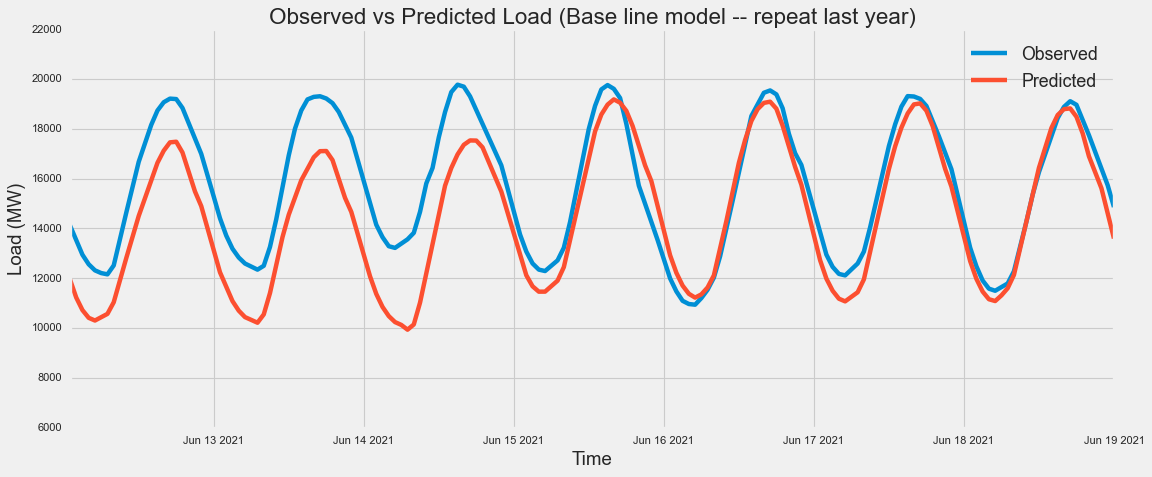

In [574]:
# plot predicted vs observed load using the Base line model
Plot_Pred(lagged_test_dict['Coast']['load'], lagged_dict['Coast']['load'].shift(8760)[-8761:],
             'Base line model -- repeat last year', scatter=False)

The Base line model (that assumes the same as last year's load consumption) resulted in MAPE of 9.98% and RMSE of 469.6. The alternative base line model (which assumes the same as previous hour) has a very small MAPE of 2.85% and RMSE of 470. This model seems good at first sight, however, it can only predict one hour in the future or if used for longer prediction, it will predict the same value again and again. We can not use this model at all.
<p>&nbsp;</p>

##  3.8 Linear regression models


To start the modeling process, we will first try some basic Regression models. Linear regression will be tested first followed by Ridge and Elastic Net.

<font color='teal'>For a moment we will focus only on one region. We will predict the load consumption for the Coast region.</font>


### 3.8.1 Simple linear regression

In [523]:
# get X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = SplitEncodeTranf('Coast')

In [524]:
# Basic Linear regression model
# X_train = X_train.drop(columns=['load_lag1','load_lag2','load_lag3'], axis=1)
# X_test = X_test.drop(columns=['load_lag1','load_lag2','load_lag3'], axis=1)

ln_model = LinearRegression()
ln_model.fit(X_train,y_train)

LinearRegression()

In [536]:
ErrorMetrics(y_train,ln_model.predict(X_train),'Linear Regression')

Error metrics for Linear Regression
R2 score = 0.9970
MAE = 106.1098
RMSE =  145.7855
MAPE =  0.9612%


In [537]:
ErrorMetrics(y_test,ln_model.predict(X_test),'Linear Regression')

Error metrics for Linear Regression
R2 score = 0.9965
MAE = 113.3267
RMSE =  153.8327
MAPE =  0.9048%


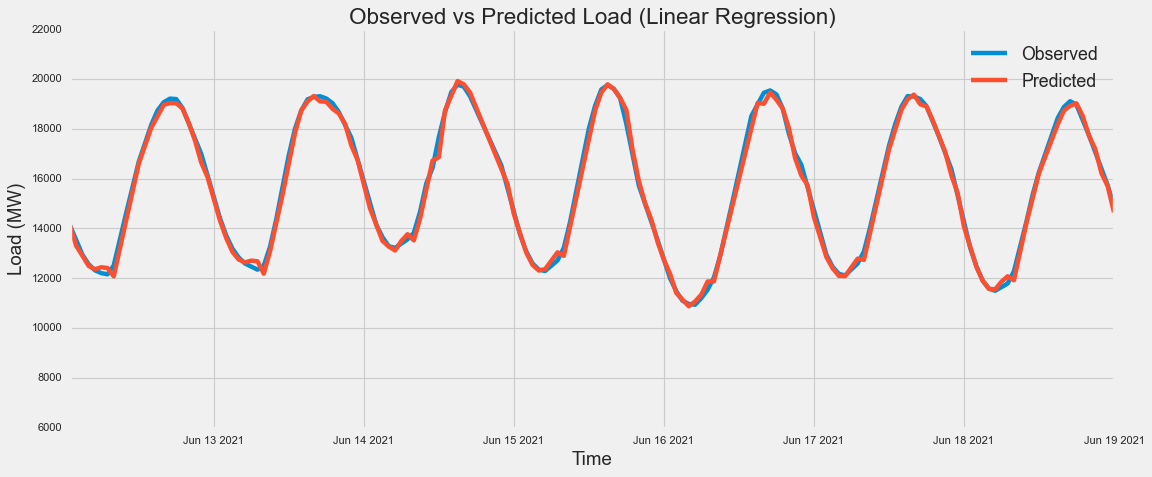

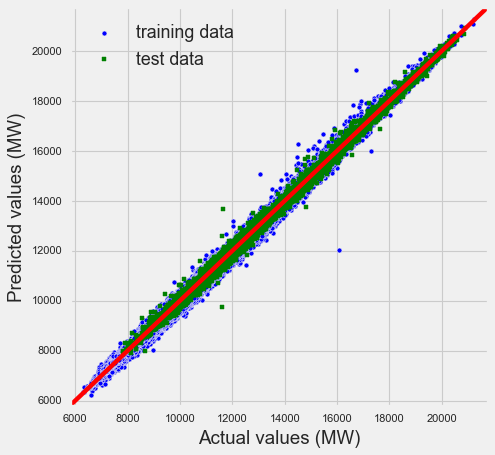

In [575]:
Plot_Pred(y_test, ln_model.predict(X_test), 'Linear Regression', scatter=True)

The above result is quite surprisingly good. The model performed very well both for the training and test datasets. The linear regression model achieved a MAPE of 0.96% and 0.91% for the training and test dataset respectively. RMSE is also quite low with 145.79 for training dataset and 153.8 for test dataset.

The plot showing observed vs predicted also looks good. The predicted values are almost overlapping with the observed values. The scatter plot also shows a good fit with the 45 degree line.

#### Check the coefficients

Next we examine the coefficients. For simplicity we will normalize the coefficients by the maximum value and multiply by 100. The most dominant coefficient will be at 100.

In [316]:
coefficients_norm = 100.0 * (ln_model.coef_ / ln_model.coef_.max())
list1 = X_train.columns.values
coef_df = pd.DataFrame(list(zip(list1,coefficients_norm)), columns=['name','coef'])

In [317]:
coef_df['abs_coef'] = np.abs(coef_df['coef'])
coef_df = coef_df.sort_values('abs_coef', ascending=False)
top_50_coef = coef_df[:50].reset_index()
top_50_coef.head()

,index,name,coef,abs_coef
0,15,load_lag1,100.000000,100.000000
1,16,load_lag2,-67.751885,67.751885
2,17,load_lag3,26.001888,26.001888
3,10,WindChillC,-8.311162,8.311162
4,18,load_lag4,-7.984822,7.984822


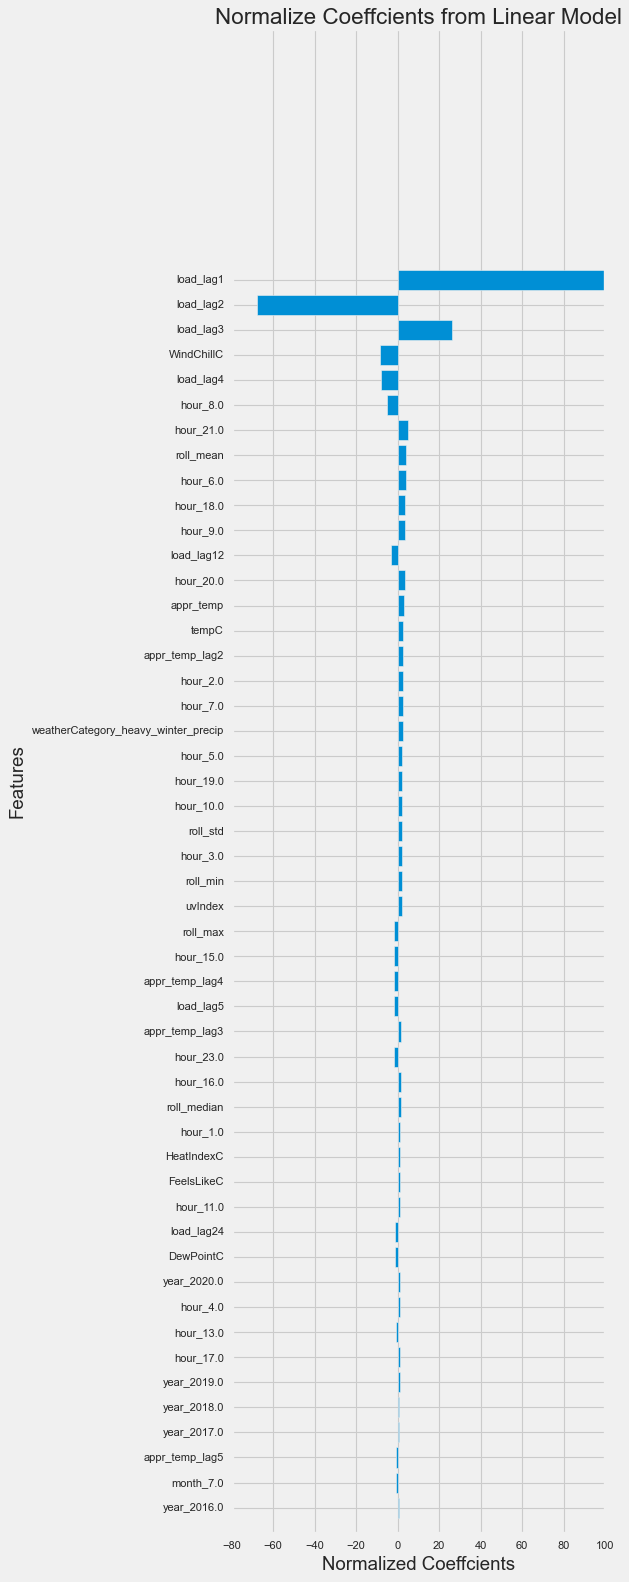

In [559]:
# plotting the top 50 linear regression model coefficients
fig,ax = plt.subplots(figsize=(8,20))

ax.barh(top_50_coef.index, top_50_coef['coef'])
plt.yticks(top_50_coef.index, top_50_coef.name)
ax.invert_yaxis()
ax.set_xlabel('Normalized Coeffcients')
ax.set_ylabel('Features')
ax.set_title('Normalize Coeffcients from Linear Model')
fig.tight_layout()
plt.show()

Investigating the coefficients show that the most dominant features are the load lag feature we created. Load_lag1, load_lag2 are by the most dominant, followed by load_lag3, windchil and load_lag4.

In [566]:
# bottom 50
bottom_50_coef = coef_df.sort_values('abs_coef', ascending=True)
bottom_50_coef = bottom_50_coef[:50].reset_index()
bottom_50_coef.head(50).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
index,140,46,44,54,106,32,101,116,45,111,118,107,43,144,114,90,61,49,29,102,53,48,146,108,51,23,2,91,117,121,65,25,145,27,113,115,52,109,89,105,94,47,5,93,103,122,128,120,7,6
name,year_2021.0,appr_temp_lag168,appr_temp_lag120,appr_temp_lag8760,day_19.0,load_lag768,day_14.0,day_29.0,appr_temp_lag144,day_24.0,day_31.0,day_20.0,appr_temp_lag48,weekday_Thursday,day_27.0,day_3.0,weatherCategory_heavy_rain,appr_temp_lag360,load_lag360,day_15.0,appr_temp_lag8064,appr_temp_lag336,weekday_Wednesday,day_21.0,appr_temp_lag672,load_lag48,winddirDegree,day_4.0,day_30.0,month_4.0,weatherCategory_sunny,load_lag144,weekday_Tuesday,load_lag192,day_26.0,day_28.0,appr_temp_lag768,day_22.0,day_2.0,day_18.0,day_7.0,appr_temp_lag192,visibility,day_6.0,day_16.0,month_5.0,month_11.0,month_3.0,cloudcover,pressure
coef,0.0,-0.000188,-0.001446,0.003397,0.003433,0.003902,-0.00552,0.006142,-0.007147,0.00761,-0.008841,0.010124,-0.011641,0.012083,-0.013232,0.014065,-0.016779,0.017178,0.018683,0.01925,0.020428,-0.021365,0.024193,0.026485,0.02872,0.031477,-0.032823,-0.034033,0.03527,-0.037331,0.041704,0.045255,0.045514,0.046865,0.050089,0.055683,-0.055721,0.057837,0.058179,0.058329,0.059029,-0.059055,0.059887,0.061259,0.063193,-0.06788,-0.06932,-0.073865,0.079979,-0.081212
abs_coef,0.0,0.000188,0.001446,0.003397,0.003433,0.003902,0.00552,0.006142,0.007147,0.00761,0.008841,0.010124,0.011641,0.012083,0.013232,0.014065,0.016779,0.017178,0.018683,0.01925,0.020428,0.021365,0.024193,0.026485,0.02872,0.031477,0.032823,0.034033,0.03527,0.037331,0.041704,0.045255,0.045514,0.046865,0.050089,0.055683,0.055721,0.057837,0.058179,0.058329,0.059029,0.059055,0.059887,0.061259,0.063193,0.06788,0.06932,0.073865,0.079979,0.081212


Most of the apparent temperature lags, the categorical features for day, month ended up in the bottom 50 features. More close examination is needed to decide whether to utlize these features moving forward or not

### 3.8.2 Elastic net regression

Elastic net regression combines the effect of Ridge and Lasso regression methods

In [567]:
# Elastic Net regression
elc_model = ElasticNet()
elc_model.fit(X_train,y_train)

ElasticNet()

In [568]:
ErrorMetrics(y_train,elc_model.predict(X_train),'Elastic Net Regression')

Error metrics for Elastic Net Regression
R2 score = 0.9512
MAE = 452.4468
RMSE =  584.3889
MAPE =  4.0342%


In [569]:
ErrorMetrics(y_test,elc_model.predict(X_test),'Elastics Net Regression')

Error metrics for Elastics Net Regression
R2 score = 0.9316
MAE = 532.5423
RMSE =  677.5661
MAPE =  4.2941%


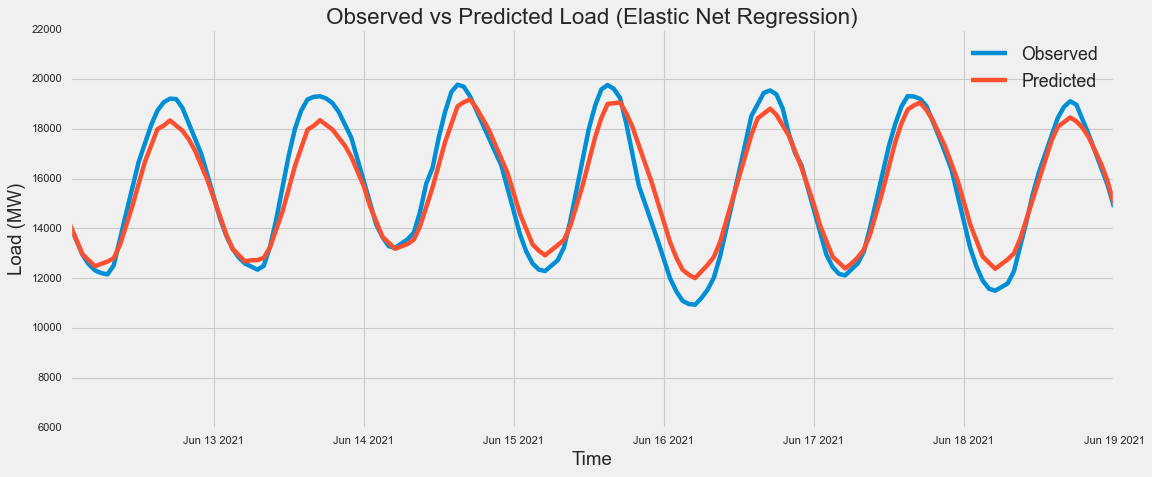

In [576]:
Plot_Pred(y_test, elc_model.predict(X_test), 'Elastic Net Regression')

Compared to simple linear regression the Elastic regression performed worse. The MAPE is 4.3% for the test data compared to 0.91% for the linear regression. The prediction power of the elastic model is suffering in the peak and trough values.
<p>&nbsp;</p>

## 3.9 Random forest

We will test random forest ensemble method

In [415]:
rf_model = RandomForestRegressor()
rf_model.fit(X_train,y_train)

RandomForestRegressor()

In [577]:
ErrorMetrics(y_train,rf_model.predict(X_train),'Random Forest Regression')

Error metrics for Random Forest Regression
R2 score = 0.9997
MAE = 34.5698
RMSE =  49.2508
MAPE =  0.3068%


In [578]:
ErrorMetrics(y_test,rf_model.predict(X_test),'Random Forest Regression')

Error metrics for Random Forest Regression
R2 score = 0.9960
MAE = 115.8938
RMSE =  163.7885
MAPE =  0.9051%


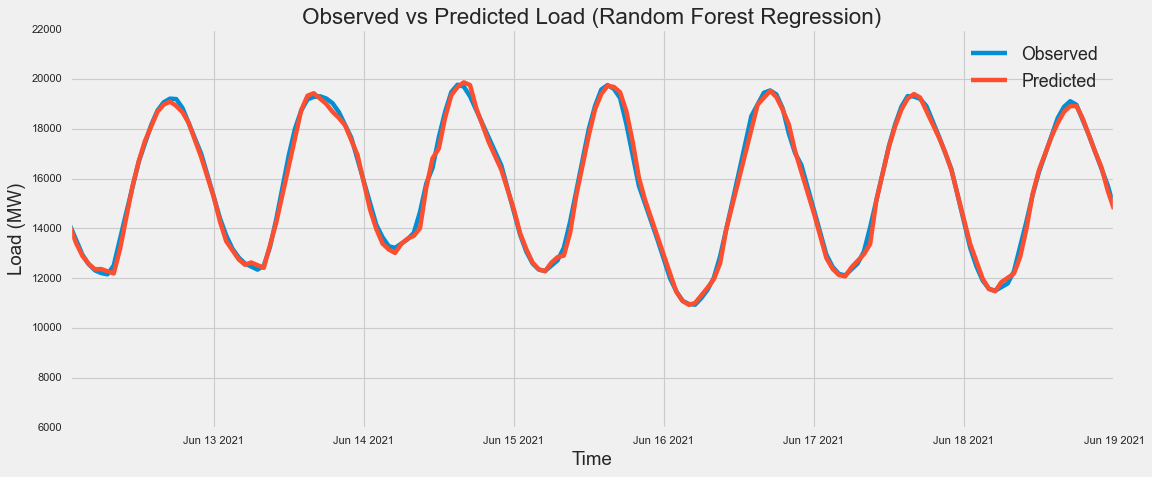

In [579]:
Plot_Pred(y_test, rf_model.predict(X_test),'Random Forest Regression')

Random forest performance is very good. It's performance is better than the linear regression on the training set with MAPE 0f 0.3% compared to 0.96%. On the test datset both model's prediction is similar. 

Below we will take a look at the feature importance from random forest

In [422]:
# rf_model.feature_importances_

In [426]:
# Random forest feature importance

RF_feature_importances_norm = 100.0 * (rf_model.feature_importances_/ rf_model.feature_importances_.max())
list1 = X_train.columns.values
RF_feat_importance_df = pd.DataFrame(list(zip(list1,RF_feature_importances_norm)), columns=['name','coef'])

In [428]:
RF_feat_importance_df['abs_coef'] = np.abs(RF_feat_importance['coef'])
RF_feat_importance_df = RF_feat_importance_df.sort_values('abs_coef', ascending=False)
RF_top_50_coef = RF_feat_importance_df[:50].reset_index()
RF_top_50_coef.head()

,index,name,coef,abs_coef
0,15,load_lag1,100.000000,100.000000
1,13,uvIndex,1.785167,1.785167
2,16,load_lag2,0.241620,0.241620
3,17,load_lag3,0.230804,0.230804
4,20,load_lag6,0.114971,0.114971


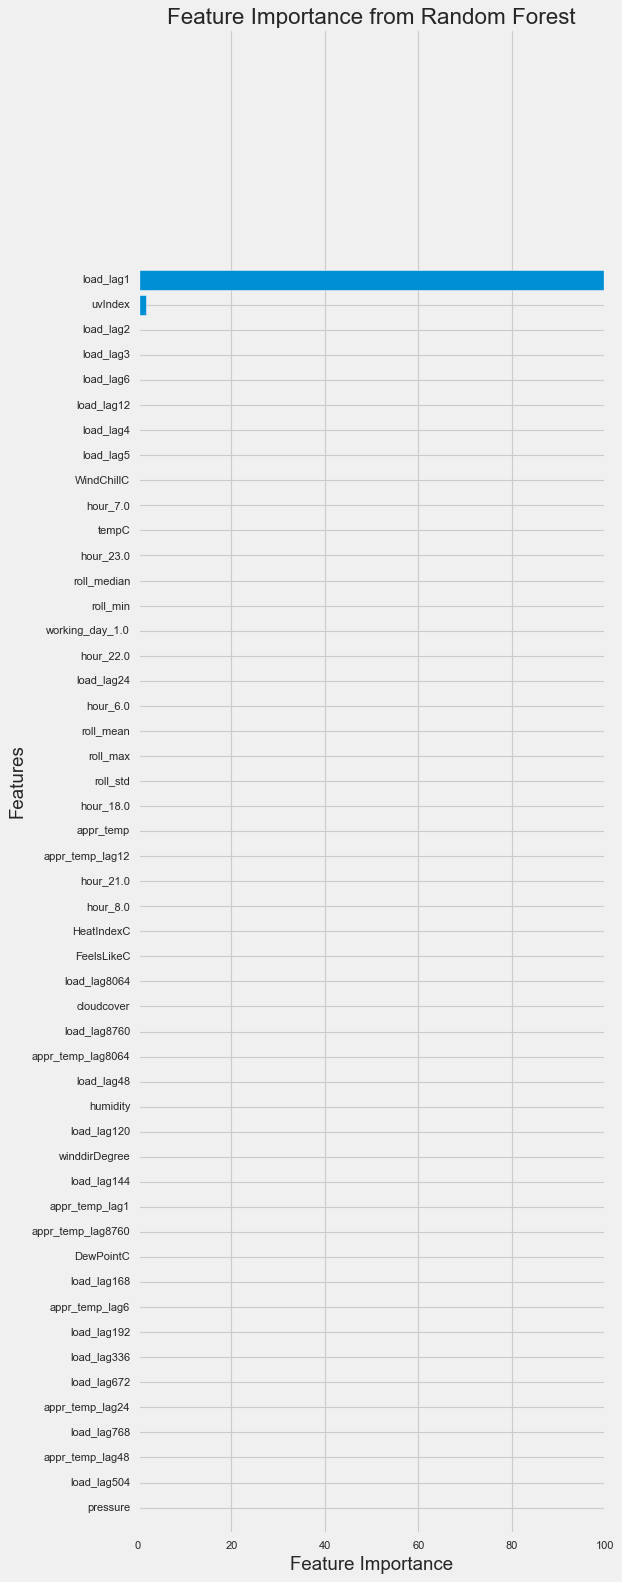

In [580]:
# plotting the top 50 Random Forest model coefficients
fig,ax = plt.subplots(figsize=(8,20))

ax.barh(RF_top_50_coef.index, RF_top_50_coef['coef'])
plt.yticks(RF_top_50_coef.index, RF_top_50_coef.name)

ax.set_xlabel('Feature Importance')
ax.set_ylabel('Features')
ax.set_title('Feature Importance from Random Forest')

fig.tight_layout()
ax.invert_yaxis()
plt.show()

The feature importance from random forest shows that load_lad1 is again by the most important feature. It is too dominant, the next improtant feature is lower by ~98% lower compared to load_lad1. 
<p>&nbsp;</p>

## 3.10 Comparison of model performace
First we will compute the residuals (observed - predicted) for the three models. we will plot and examine the distribution of the errors and finally compute the upper and lower bound 95% confidence interval

In [679]:
# calculate the residuals

ln_model_residuals = Residuals(y_test, ln_model.predict(X_test))
elc_model_residuals = Residuals(y_test, elc_model.predict(X_test))
rf_model_residuals = Residuals(y_test, rf_model.predict(X_test))

In [680]:
# create a dataframe containing the three residuals

model_names = ['Linear Regression','Elastic Net','Random Forest']
residual_list = list(zip(ln_model_residuals,elc_model_residuals,rf_model_residuals))
residuals_df = pd.DataFrame(residual_list, columns=model_names)
residuals_df.head()

,Linear Regression,Elastic Net,Random Forest
0,96.706241,-797.093546,-50.382216
1,-15.494730,-844.783430,60.552124
2,68.574994,-757.662760,47.207971
3,8.569522,-645.773339,-38.824819
4,0.054505,-690.331518,7.784505


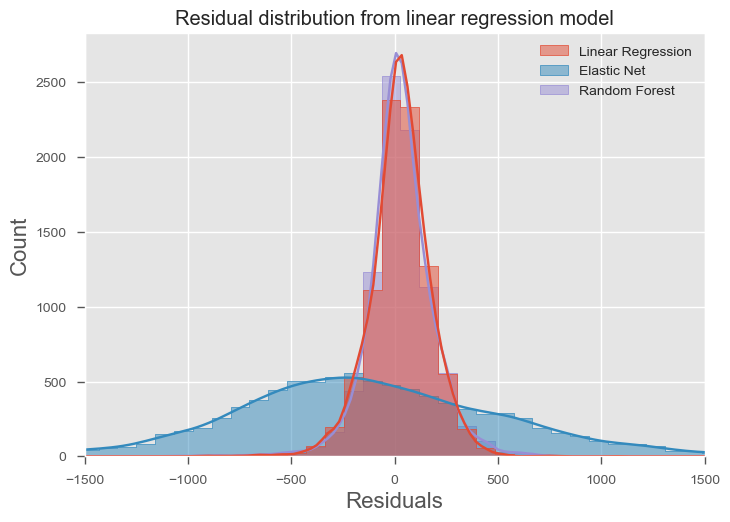

In [681]:
plt.style.use('ggplot')
sns.histplot(residuals_df, bins=60, element='step', alpha=0.5, kde=True)
plt.xlabel('Residuals', fontsize = 16)
plt.ylabel('Count', fontsize = 16)
plt.title('Residual distribution from linear regression model')
plt.xlim([-1500,1500])
plt.show()

The residual distributions for both linear model and random forest are narrow and are centered around zero, indicating the two models are performing good. The distribution of the Elastic net is quite the opposite, it is very wide and is slightly skewed to the left indicating bad performance.

In [682]:
# Prepare a summary dataframe comparing the three models, errors and confidence intervals
mdl_name = [ln_model,elc_model,rf_model]
residual_list = [ln_model_residuals,elc_model_residuals,rf_model_residuals]

model_summary_dict = {}

for name, residual in zip(mdl_name, residual_list):
    r2, rmse, mape = ErrorMetrics(y_test, name.predict(X_test))
    upper,lower = LowerUpperBound(residual)
    
    model_summary_dict[name]=r2,rmse,mape,upper,lower

model_summary_df = pd.DataFrame(model_summary_dict)

Error metrics for None
R2 score = 0.9965
MAE = 113.3267
RMSE =  153.8327
MAPE =  0.9048%
Error metrics for None
R2 score = 0.9316
MAE = 532.5423
RMSE =  677.5661
MAPE =  4.2941%
Error metrics for None
R2 score = 0.9960
MAE = 115.8938
RMSE =  163.7885
MAPE =  0.9051%


In [683]:
model_summary_df.columns = ['Linear Regression','Elastic Net','Random Forest']
model_summary_df.index = ['R2','RMSE','MAPE','Lower_bound', 'Upper_bound']
model_summary_df.T

,R2,RMSE,MAPE,Lower_bound,Upper_bound
Linear Regression,0.996474,153.832683,0.904796,-269.014425,324.238854
Elastic Net,0.931592,677.566074,4.294057,-1432.124979,1176.261917
Random Forest,0.996003,163.788538,0.905095,-287.213922,344.846611


## 3.11 Saving models

Below we will save the three models for later use.

In [699]:
linear_reg_model = ln_model
linear_reg_model.version = '1.0'
linear_reg_model.pandas_version = pd.__version__
linear_reg_model.numpy_version = np.__version__
linear_reg_model.sklearn_version = sklearn_version
linear_reg_model.X_columns = [col for col in X_train.columns]
linear_reg_model.build_datetime = datetime.now()

elasticnet_model = elc_model
elasticnet_model.version = '1.0'
randomforest_model = rf_model
randomforest_model.version = '1.0'

modelpath = './models'
save_file(linear_reg_model, 'Linear_regression_forecasting_model.pkl', modelpath)
save_file(elasticnet_model, 'Elastic_Net_regression_forecasting_model.pkl', modelpath)
save_file(randomforest_model, 'Random_Forest_forecasting_model.pkl', modelpath)

A file already exists with this name.

Do you want to overwrite? (Y/N)Y
Writing file.  "./models/Linear_regression_forecasting_model.pkl"
A file already exists with this name.

Do you want to overwrite? (Y/N)Y
Writing file.  "./models/Elastic_Net_regression_forecasting_model.pkl"
A file already exists with this name.

Do you want to overwrite? (Y/N)Y
Writing file.  "./models/Random_Forest_forecasting_model.pkl"


## 3.12 Summary

In this note book we have read the combined load,weather and covid data and performed the following steps:
- Feature engineering --- we have created several new features to be used for model prediction, these include
    - Lagged features for the `load and apparent temperature` columns. The lagged features were created for several laggs
    - Rolling statstical features such as mean, median, standard deviation, minimum and maximum values for a window of 24 hours. 

- Splitted the data set into two dictionaries containing the training and the test dataset. We kept one year data as a test set and the remaining 11 years of data will be used for training.
- Dropped some columns that are not relevant and also the two columns with Covid19 information. The reason for dropping the Covid19 info at this moment is they are almost exclusively present in the test data. We don't have enough Covid19 data in the training set.
- Wrote a function that encodes categrocial variables, splits the data into X_tain, X_test, y_train and y_test and  applies standard scalling to the X_train and X_test datasets
- Wrote functions to calaculate the error metrics and plot observed vs predicted values
- We created a base line model. A simple base line model that predicts the future load consumption to be the same as last year's consumption is created. The MAPE and RMSE are 9.98% and 469.6 respectively
- Simple linear regression and Elastic Net regression models are also biult. The linear model performance is way better than the Elastic net. No hyperparameter tunning is done at this moment. This models are built just to give us the feel of the data. 
    - The MAPE and RMSE for the linear regression model are 0.91% and 153.8
    - The MAPE and RMSE for the elastic net regression model are 4.3% and 677.6
- Random forest model is also generated , using default values. Its performance is also good and similar to the linear regression.
    - The MAPE and RMSE for the random forest model are 0.91% and 163.8
- The residuals for the three models are compared. Both the linear model and the random forest have a very narrow distribution compred to the elastic net residuals. they are also center around zero where as the elastic net residual distribution is skewed to the left.


More analysis and investigation will be done before proceeding into building model using XGB, SARIMAX